In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time
from idlmam import train_simple_network, set_seed

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(1)

/tmp/ipykernel_24237/3591515336.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
import torchvision
from torchvision import transforms, datasets

### Try training all the networks in this chapter for 40 epochs instead of 10. What happens?

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

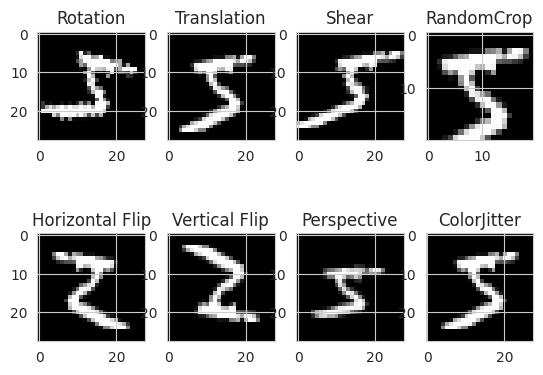

In [6]:
# prepare data
B = 32
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
x_example, y_example = mnist_data_train[0]
# print(x_example.shape)

mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

#Several built-in transformations, given some agressive values to make their impact more obvious.
sample_transforms = {
    "Rotation" : transforms.RandomAffine(degrees=45),
    "Translation" : transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
    "RandomCrop" : transforms.RandomCrop((20,20)),
    "Horizontal Flip" : transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),
    "ColorJitter" : transforms.ColorJitter(brightness=0.9, contrast=0.9)
}

img_indx = 0
img, correct_class = mnist_data_train[img_indx]
img = img[0,:]
#Convert the Tensor image back to a PIL image using a transform
pil_img = transforms.ToPILImage()(img)
#Plot a randomy application of each transform
f, axarr = plt.subplots(2,4)
for count, (name, t) in enumerate(sample_transforms.items()):
    row = count % 4
    col = count // 4
    axarr[col,row].imshow(t(pil_img), cmap='gray')
    axarr[col,row].set_title(name)
plt.show()

train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.98, 1.02)),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

mnist_train_t = torchvision.datasets.MNIST("./data", train=True, transform=train_transform)
mnist_test_t = torchvision.datasets.MNIST("./data", train=False, transform=test_transform)
mnist_train_loader_t = DataLoader(mnist_train_t, shuffle=True,  batch_size=B, num_workers=5)
mnist_test_loader_t = DataLoader(mnist_test_t, batch_size=B, num_workers=5)

In [7]:
# define networks
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10
#How many filters should we use
filters = 16
#How large should our filters be?
K = 3
#How many epoch should be trained?
epochs = 40

#for comparison, lets define a linear model of similar complexity
model_linear = nn.Sequential(
  nn.Flatten(), #(B, C, W, H) -> (B, C*W*H) = (B,D)
  nn.Linear(D, 256),
  nn.Tanh(),
  nn.Linear(256, classes),
)

#A simple convolutional network:
model_cnn = nn.Sequential(
  #Conv2d follows the pattern of:
  #Conv2d(# of input channels, #filters/output-channels, #filter-size)
  nn.Conv2d(C, filters, K, padding=K//2), #$x \circledast G$
  nn.Tanh(),#Activation functions work on any size tensor
  nn.Flatten(), #Convert from (B, C, W, H) ->(B, D). This way we can use a Linear layer after
  nn.Linear(filters*D, classes),
)

model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),

  nn.Flatten(),
  #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times.
  nn.Linear(2*filters*D//(4**2), classes),
)




In [8]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_simple_network(model_cnn, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

fc_results = train_simple_network(model_linear, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

cnn_results_with_pool = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

cnn_results_with_pool_augmented = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader_t, test_loader=mnist_test_loader_t, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

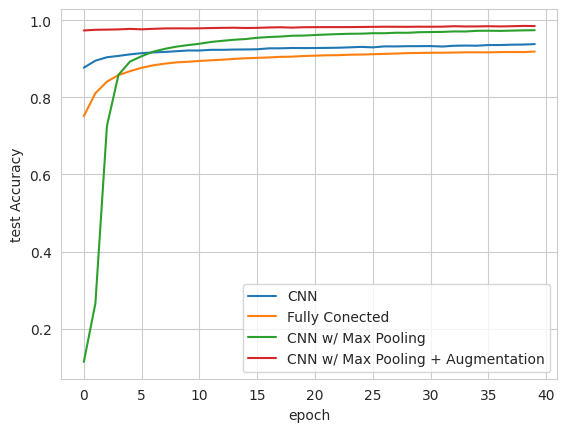

In [9]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results, label='Fully Conected')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool_augmented, label='CNN w/ Max Pooling + Augmentation')

Only Fully Connected and CNN w/Max Pooling seems to improve, rest of them seems to stay at same level

### Load the CIFAR10 dataset from torchvision, and try to build your own CNN. Try using 2 to 10 layers of convolutions and 0 to 2 rounds of max pooling. What seems to work best?

In [5]:
B = 32

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_train_loader = DataLoader(trainset, batch_size=B)
cifar10_test_loader = DataLoader(testset, batch_size=B)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# define networks
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 32*32 #32 * 32 images
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 10
#How many filters should we use
filters = 16
#How large should our filters be?
K = 3
#How many epoch should be trained?
epochs = 20


In [8]:
model_cnn_l2_mp0 = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(filters*D, classes)
)

model_cnn_l2_mp1 = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times.
    nn.Linear(2*filters*D//(4**1), classes)
)

model_cnn_l2_mp2 = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times.
    nn.Linear(2*filters*D//(4**2), classes)
)

model_cnn_l3_mp1 = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.Flatten(),
    nn.Linear(2*filters*D//(4**1), classes)
)

model_cnn_l8_mp0 = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(filters*D, classes)
)

model_cnn_l7_mp2 = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times.
    nn.Linear(2*filters*D//(4**2), classes)
)

model_cnn_l10_mp2 = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times.
    nn.Linear(2*filters*D//(4**2), classes)
)

In [9]:
loss_func = nn.CrossEntropyLoss()

cnn_results_l2_mp0 = train_simple_network(model_cnn_l2_mp0, loss_func, cifar10_train_loader, test_loader=cifar10_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

cnn_results_l2_mp1 = train_simple_network(model_cnn_l2_mp1, loss_func, cifar10_train_loader, test_loader=cifar10_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

cnn_results_l2_mp2 = train_simple_network(model_cnn_l2_mp2, loss_func, cifar10_train_loader, test_loader=cifar10_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

cnn_results_l3_mp1 = train_simple_network(model_cnn_l3_mp1, loss_func, cifar10_train_loader, test_loader=cifar10_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

cnn_results_l8_mp0 = train_simple_network(model_cnn_l8_mp0, loss_func, cifar10_train_loader, test_loader=cifar10_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

cnn_results_l7_mp2 = train_simple_network(model_cnn_l7_mp2, loss_func, cifar10_train_loader, test_loader=cifar10_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

cnn_results_l10_mp2 = train_simple_network(model_cnn_l10_mp2, loss_func, cifar10_train_loader, test_loader=cifar10_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

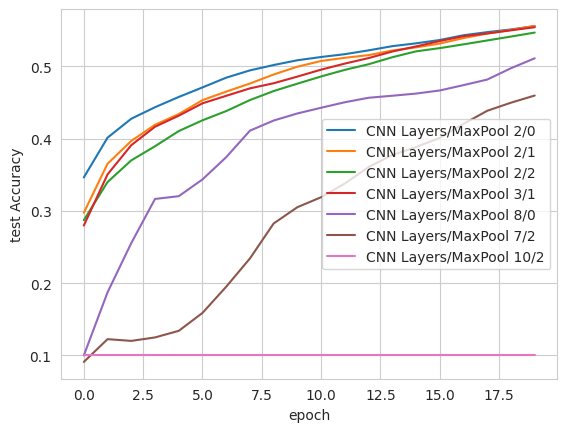

In [10]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_l2_mp0, label='CNN Layers/MaxPool 2/0')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_l2_mp1, label='CNN Layers/MaxPool 2/1')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_l2_mp2, label='CNN Layers/MaxPool 2/2')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_l3_mp1, label='CNN Layers/MaxPool 3/1')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_l8_mp0, label='CNN Layers/MaxPool 8/0')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_l7_mp2, label='CNN Layers/MaxPool 7/2')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_l10_mp2, label='CNN Layers/MaxPool 10/2')


We have only trained a few epoch, but it seems like too many layers have a negative effect on our results. It doesn't help to increase the number of layers and the number of maxpool.

### Go through the transforms provided and see which makes sense for CIFAR10 via visual inspection. Do any transforms work for CIFAR10 that do not make sense for MNIST?

Files already downloaded and verified
Files already downloaded and verified


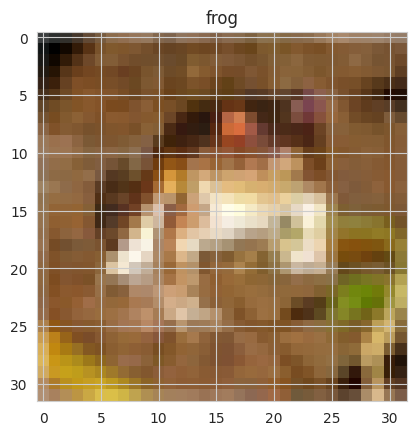

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True)

img_indx = 0
img, correct_class = trainset[img_indx]

plt.imshow(img)
plt.title("frog")
plt.show()

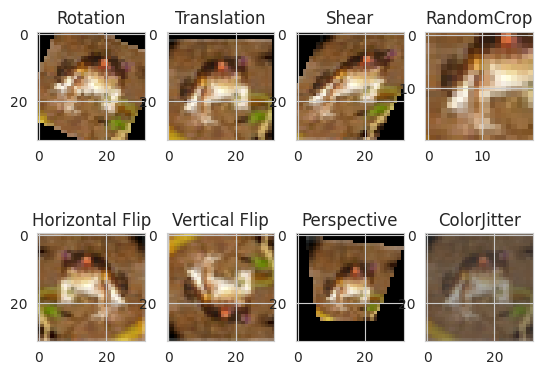

In [6]:
sample_transforms = {
    "Rotation" : transforms.RandomAffine(degrees=45),
    "Translation" : transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
    "RandomCrop" : transforms.RandomCrop((20,20)),
    "Horizontal Flip" : transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),
    "ColorJitter" : transforms.ColorJitter(brightness=0.9, contrast=0.9),
    #"Normalize": transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    #"RandomGray": transforms.RandomGrayscale(p=0.1)
}
#Convert the Tensor image back to a PIL image using a transform
#pil_img = transforms.ToPILImage()(img)
#Plot a randomy application of each transform
f, axarr = plt.subplots(2,4)

for count, (name, t) in enumerate(sample_transforms.items()):
    row = count % 4
    col = count // 4
    axarr[col,row].imshow(t(img))
    axarr[col,row].set_title(name)
plt.show()

Seems like perspective doesn't make too much sense!

### Train a new CIFAR10 model with the transforms you selected. What impact does this have on accuracy?

In [5]:
B = 32
transform = transforms.Compose([
                                #transforms.RandomAffine(degrees=45),
                                #transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
                                transforms.RandomAffine(degrees=0, shear=45),
                                #transforms.RandomCrop((20,20)),
                                transforms.RandomHorizontalFlip(p=1.0),
                                transforms.RandomVerticalFlip(p=1.0),
                                #transforms.RandomPerspective(p=1.0),
                                transforms.ColorJitter(brightness=0.9, contrast=0.9),
                                # let us add two more
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])



trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_train_loader = DataLoader(trainset, batch_size=B)
cifar10_test_loader = DataLoader(testset, batch_size=B)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
x_example, y_example = trainset[0]
print(x_example.shape)

torch.Size([3, 32, 32])


In [7]:
# define networks
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 32*32 #32 * 32 images
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 10
#How many filters should we use
filters = 16
#How large should our filters be?
K = 3
#How many epoch should be trained?
epochs = 20

# print(2*filters*D//(4**2))

model2_cnn_l2_mp1 = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times.
    nn.Linear(2*filters*D//(4**1), classes)
)

In [8]:
loss_func = nn.CrossEntropyLoss()

cnn2_results_l2_mp1 = train_simple_network(model2_cnn_l2_mp1, loss_func, cifar10_train_loader, test_loader=cifar10_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

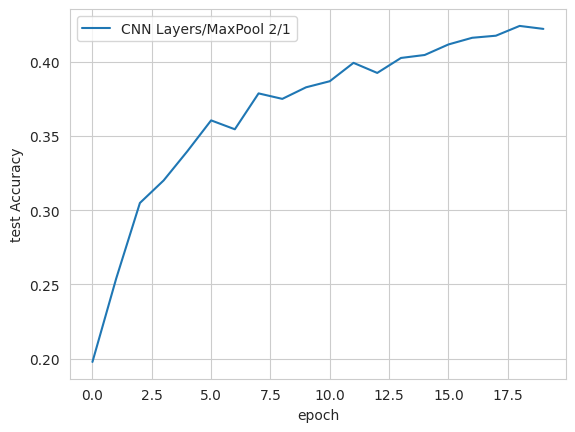

In [9]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn2_results_l2_mp1, label='CNN Layers/MaxPool 2/1')

It helps to improve, accuracy increases faster

### Try altering the size of the convolutional filters in CIFAR10 and MNIST. What impact does it have?

In [10]:
B = 32
transform = transforms.Compose([
                                #transforms.RandomAffine(degrees=45),
                                #transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
                                transforms.RandomAffine(degrees=0, shear=45),
                                #transforms.RandomCrop((20,20)),
                                transforms.RandomHorizontalFlip(p=1.0),
                                transforms.RandomVerticalFlip(p=1.0),
                                #transforms.RandomPerspective(p=1.0),
                                transforms.ColorJitter(brightness=0.9, contrast=0.9),
                                # let us add two more
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])



trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_train_loader = DataLoader(trainset, batch_size=B)
cifar10_test_loader = DataLoader(testset, batch_size=B)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# define networks
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 32*32 #32 * 32 images
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 10
#How many filters should we use
filters = 24
#How large should our filters be?
K = 3
#How many epoch should be trained?
epochs = 20

# print(2*filters*D//(4**2))

model2_cnn_l2_mp1_f24 = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times.
    nn.Linear(2*filters*D//(4**1), classes)
)

In [12]:
loss_func = nn.CrossEntropyLoss()

cnn2_results_l2_mp1_f24 = train_simple_network(model2_cnn_l2_mp1_f24, loss_func, cifar10_train_loader, test_loader=cifar10_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

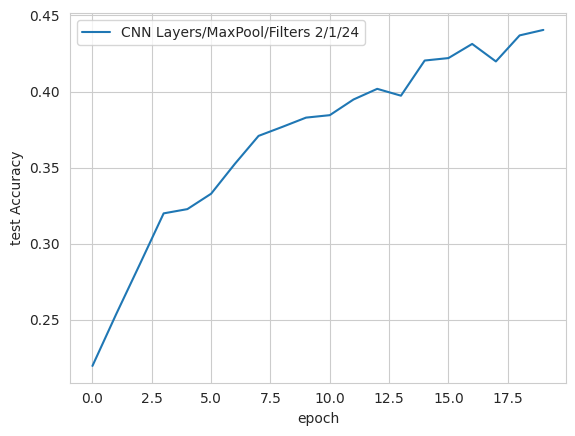

In [13]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn2_results_l2_mp1_f24, label='CNN Layers/MaxPool/Filters 2/1/24')

In [14]:
# prepare data
B = 32
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
x_example, y_example = mnist_data_train[0]
# print(x_example.shape)

train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.98, 1.02)),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()
mnist_train_t = torchvision.datasets.MNIST("./data", train=True, transform=train_transform)
mnist_test_t = torchvision.datasets.MNIST("./data", train=False, transform=test_transform)

mnist_train_loader_t = DataLoader(mnist_train_t, shuffle=True,  batch_size=B, num_workers=5)
mnist_test_loader_t = DataLoader(mnist_test_t, batch_size=B, num_workers=5)

In [15]:
# define networks
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10
#How many filters should we use
filters = 24
#How large should our filters be?
K = 3
#How many epoch should be trained?
epochs = 40

model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),

  nn.Flatten(),
  #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times.
  nn.Linear(2*filters*D//(4**2), classes),
)

In [16]:
cnn2_results_with_pool_augmented = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader_t, test_loader=mnist_test_loader_t, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

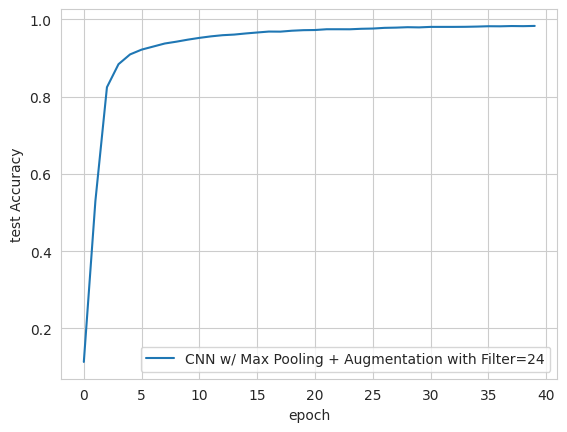

In [17]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn2_results_with_pool_augmented, label='CNN w/ Max Pooling + Augmentation with Filter=24')

So weights of the filters are one of the main parameters that are trained in our CNN >> number of filters is one of our hyperparameters for model training

### Create a new custom Shuffle transform that applies the same fixed reordering of the pixels in an image. How does using this transform impact your CIFAR10 model? Hint: Look at the Lambda transform to help you implement this.

Files already downloaded and verified
Files already downloaded and verified


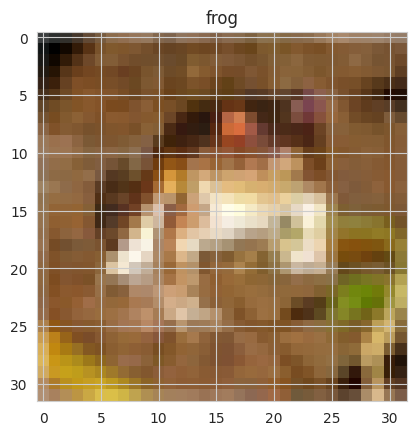

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True)

img_indx = 0
img, correct_class = trainset[img_indx]

plt.imshow(img)
plt.title("frog")
plt.show()

In [6]:
print(type(img))

<class 'PIL.Image.Image'>


In [7]:
# source
# https://stackoverflow.com/questions/66487612/how-to-shuffle-a-jpg-images-pixels-by-rows-using-pil-and-numpy
# import numpy as np
# from PIL import Image
#
# img = Image.open("donkey.jpg")
#
# # getting the number of channels
# channel_count = len(img.getbands())
#
# img_arr = np.reshape(img, (img.height, img.width, channel_count))
#
# # splitting up channels
# channels = [img_arr[:,:,x] for x in range(channel_count)]
#
# # setting up a shuffling order for rows
# random_perm = np.random.permutation(img.height)
#
# # reordering the rows with respect to the permutation
# shuffled_img_arr = np.dstack([x[random_perm, :] for x in channels]).astype(np.uint8)
#
# # creating the Image from the shuffled array
# shuffled_img = Image.fromarray(shuffled_img_arr)
#
# # saving the shuffled file
# shuffled_img.save("shuffled_donkey.jpg")
# reordering the rows with respect to the permutation
shuffled_img = np.dstack([x[np.random.RandomState(seed=42).permutation(img.height), :] for x in [np.reshape(img, (img.height, img.width, len(img.getbands())))[:,:,x] for x in range(len(img.getbands()))]]).astype(np.uint8)

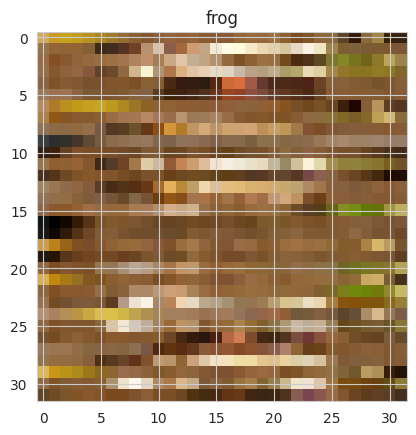

In [8]:
plt.imshow(shuffled_img)
plt.title("frog")
plt.show()

In [9]:
from PIL import Image
def shuffle_img(img):
    shuffle_img = np.dstack([x[np.random.RandomState(seed=42).permutation(img.height), :] for x in [np.reshape(img, (img.height, img.width, len(img.getbands())))[:,:,x] for x in range(len(img.getbands()))]]).astype(np.uint8)
    return Image.fromarray(shuffle_img)

In [10]:
B = 32
transform = transforms.Compose([
                                #transforms.RandomAffine(degrees=45),
                                #transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
                                transforms.Lambda(lambda img: shuffle_img(img)),
                                transforms.RandomAffine(degrees=0, shear=45),
                                #transforms.RandomCrop((20,20)),
                                transforms.RandomHorizontalFlip(p=1.0),
                                transforms.RandomVerticalFlip(p=1.0),
                                #transforms.RandomPerspective(p=1.0),
                                transforms.ColorJitter(brightness=0.9, contrast=0.9),
                                # let us add two more
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

                                ])



trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_train_loader = DataLoader(trainset, batch_size=B)
cifar10_test_loader = DataLoader(testset, batch_size=B)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# define networks
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 32*32 #32 * 32 images
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 10
#How many filters should we use
filters = 16
#How large should our filters be?
K = 3
#How many epoch should be trained?
epochs = 20

# print(2*filters*D//(4**2))

model_cnn_l2_mp1_shuffle = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.ReLU(),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times.
    nn.Linear(2*filters*D//(4**1), classes)
)

In [12]:
loss_func = nn.CrossEntropyLoss()

cnn_results_l2_mp1_shuffle = train_simple_network(model_cnn_l2_mp1_shuffle, loss_func, cifar10_train_loader, test_loader=cifar10_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

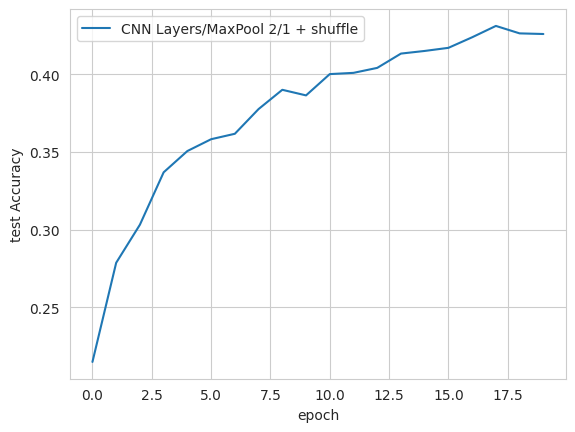

In [13]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_l2_mp1_shuffle, label='CNN Layers/MaxPool 2/1 + shuffle')

It seems to boost the training, in the first few epochs. Later on it seems like our model doesn't benefit anymore.